In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from numpy import cos
from math import log
from scipy.interpolate import interp1d
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from sage.plot.plot3d.parametric_surface import ParametricSurface
import plotly.graph_objects as go
import plotly.express as px

In [2]:
T_linha = 25.6
T1= 26.4 
T2= 0.025
omega1= 0.017
phi1= -1.45

R1= 250.083 
R2= 0.565
omega2= 0.02
phi2=1.6

B_E=200
p_ME=0.9
p_ML=0.75
p_MP=0.85
tau_E=1
tau_P=1
# c1=0.019
# c2=-0.021
c1=0.00554
c2=-0.06737
mu_H = 0.00007

D1=36.5
b1=0.04

A=12.5
B=15
C=-48.78

b2=0.09
tau_H=10
DD=105
Tmin=14.5
gamma= 1/120 #365 
R_L = 450
N = 7717 #População estimada para 2004
M = 300000 
k=1 #Análise sem efeito do desmatamento

E_M0 = 1 #Analisando a infecção iniciando com apenas um mosquito exposto e um humano infectado
I_H0 = 1
I_M0 = 0
R_H0 = 0
if E_M0 is None:
        E_M0 = M / 100

S_H0 = N - I_H0 - R_H0
S_M0 = M - E_M0 - I_M0

In [3]:
def model(t, z, T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0, R_H0, mu_H, k):
    
    S_H, I_H, R_H, S_M, E_M, I_M = z
    
    # Funções de temperatura e chuva
    def Temp(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))

    def Rain(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))

    R_curr = Rain(t)
    T_curr = Temp(t)
    
    # Duração da fase de desenvolvimento das larvas
    def tau_L(Temp):
        return 1 / (c1 * Temp + c2)
    
    # Taxa diária de sobrevivência dos mosquitos
    def p(Temp):
        return np.exp(-1 / (A*Temp**2 + B*Temp + C))
    
    # Probabilidade de sobrevivência das larvas dependente de temperatura e chuva
    def p_LT(Temp):
        return np.exp(-(c1 * Temp + c2))
    
    def p_LR(Rain):
        return (4*p_ML/R_L**2) * Rain * (max(10^-5,R_L - Rain))
    
    def p_LRT(Rain,Temp):
        return p_LR(Rain)*p_LT(Temp)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_ER(Rain):
        return (4*p_ME/R_L**2) * Rain * (max(10^-5,R_L - Rain))
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_PR(Rain):
        return (4*p_MP/R_L**2) * Rain * (max(10^-5,R_L - Rain))

    # Duração do ciclo esporogônico
    def tau_M(Temp):
        return DD / (max(10^-5,Temp - Tmin))
    
    tau_M_curr = tau_M(T_curr)

    # Taxa de infecção de expostos (1/Duração do ciclo esporogônico)
    def b3(tau_M, Temp):
        return 1/tau_M
    
    b3_curr = b3(tau_M_curr, T_curr)
    
    # Definindo a função de sobrevivência do mosquito
    def l_tau_M(tau_M, Temp):  
        p_T = p(Temp)
        return p_T**tau_M
    
    l_curr = l_tau_M(tau_M_curr, T_curr)

    # Definindo a taxa de mortalidade do mosquito
    def mu(Temp):
        return -log(p(Temp))
    
    mu_curr = mu(T_curr)
    
    # Calcula a taxa de picada e probabilidade de transmissão
    def a(Temp):
        return (max(10^-5, Temp - T_linha)) / D1
    
    a_curr = a(T_curr)
    
    def b(Rain,Temp):
        return B_E * p_ER(Rain) * p_LRT(Rain,Temp) * p_PR(Rain) / (tau_E + tau_L(Temp) + tau_P)
    
    b_curr = b(R_curr, T_curr)
    
    dShdt = mu_H * N -a_curr * k * b2 * (I_M / N) * S_H - mu_H * S_H
    dIhdt = a_curr * k * b2 * (I_M / N) * S_H - gamma * I_H - mu_H * I_H
    dRhdt = gamma * I_H - mu_H * R_H
    
    dSmdt = b_curr - a_curr * k * b1 * (I_H / N) * S_M - mu_curr * S_M
    dEmdt = a_curr * k * b1 * (I_H / N) * S_M - mu_curr * E_M - b3_curr * E_M - l_curr * E_M
    dImdt = b3_curr * E_M - mu_curr * I_M
    
    return [dShdt, dIhdt, dRhdt, dSmdt, dEmdt, dImdt] 

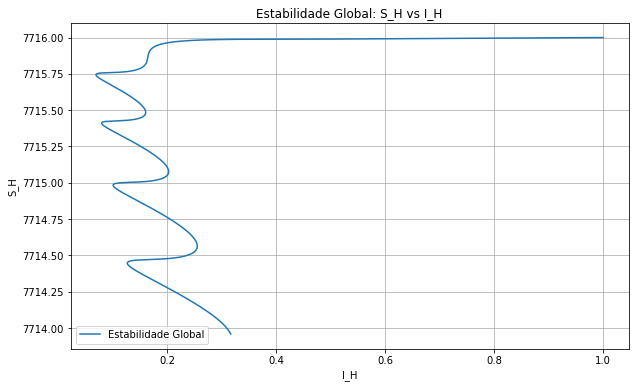

In [4]:
args = (T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0, R_H0, mu_H, k)

t_span = (0, 1825)  

initial_conditions = [S_H0, I_H0, R_H0, S_M0, E_M0, I_M0]

# Resolve o sistema de EDOs
solution = solve_ivp(model, t_span, initial_conditions,  args=args, method='RK45', dense_output=True)

# Extrai os resultados
t_values = np.linspace(t_span[0], t_span[1], 1000)
z_values = solution.sol(t_values)

# Plota S_H vs I_H
plt.figure(figsize=(10, 6))
plt.plot(z_values[1], z_values[0], label='Estabilidade Global')
plt.title('Estabilidade Global: S_H vs I_H')
plt.xlabel('I_H')
plt.ylabel('S_H')
plt.legend()
plt.grid(True)
plt.show()

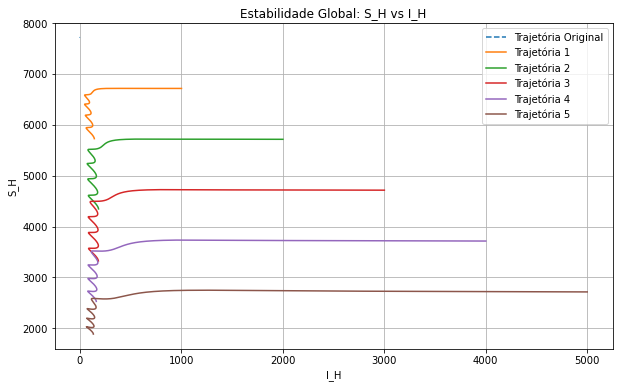

In [5]:
t_span = (0, 1825)

# Condições iniciais
initial_conditions = [S_H0, I_H0, R_H0, S_M0, E_M0, I_M0]

# Número de trajetórias a anlisar
num_trajectories = 5

# Plotagem das múltiplas trajetórias
plt.figure(figsize=(10, 6))

original_solution = solve_ivp(model, t_span, initial_conditions, args=args, method='RK45', dense_output=True)
original_z_values = original_solution.sol(t_values)
plt.plot(original_z_values[1], original_z_values[0], label='Trajetória Original', linestyle='--')    

for i in range(num_trajectories):
    
    initial_conditions[0] -= 1000  # Aumentando o número de infectados inicial em 1000
    initial_conditions[1] += 1000
    solution = solve_ivp(model, t_span, initial_conditions, args=args, method='RK45', dense_output=True)
    
    # Extrai os resultados
    t_values = np.linspace(t_span[0], t_span[1], 1000)
    z_values = solution.sol(t_values)

    # Plota S_H vs I_H para cada trajetória
    plt.plot(z_values[1], z_values[0], label=f'Trajetória {i+1}')
    
plt.title('Estabilidade Global: S_H vs I_H')
plt.xlabel('I_H')
plt.ylabel('S_H')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
k=2.0746963059512207

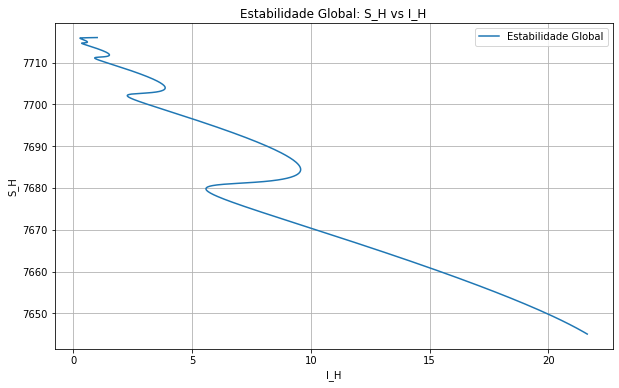

In [7]:
args = (T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0, R_H0, mu_H, k)

t_span = (0, 1825)  

initial_conditions = [S_H0, I_H0, R_H0, S_M0, E_M0, I_M0]

# Resolve o sistema de EDOs
solution = solve_ivp(model, t_span, initial_conditions,  args=args, method='RK45', dense_output=True)

# Extrai os resultados
t_values = np.linspace(t_span[0], t_span[1], 1000)
z_values = solution.sol(t_values)

# Plota S_H vs I_H
plt.figure(figsize=(10, 6))
plt.plot(z_values[1], z_values[0], label='Estabilidade Global')
plt.title('Estabilidade Global: S_H vs I_H')
plt.xlabel('I_H')
plt.ylabel('S_H')
plt.legend()
plt.grid(True)
plt.show()

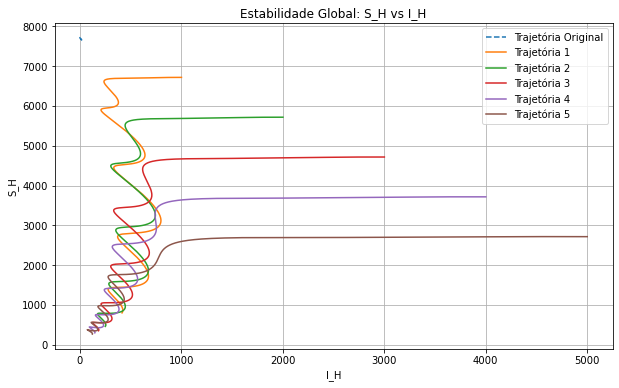

In [8]:
t_span = (0, 1825)

# Condições iniciais
initial_conditions = [S_H0, I_H0, R_H0, S_M0, E_M0, I_M0]

# Número de trajetórias a anlisar
num_trajectories = 5

# Plotagem das múltiplas trajetórias
plt.figure(figsize=(10, 6))

original_solution = solve_ivp(model, t_span, initial_conditions, args=args, method='RK45', dense_output=True)
original_z_values = original_solution.sol(t_values)
plt.plot(original_z_values[1], original_z_values[0], label='Trajetória Original', linestyle='--')    

for i in range(num_trajectories):
    
    initial_conditions[0] -= 1000  # Aumentando o número de infectados inicial em 1000
    initial_conditions[1] += 1000
    solution = solve_ivp(model, t_span, initial_conditions, args=args, method='RK45', dense_output=True)
    
    # Extrai os resultados
    t_values = np.linspace(t_span[0], t_span[1], 1000)
    z_values = solution.sol(t_values)

    # Plota S_H vs I_H para cada trajetória
    plt.plot(z_values[1], z_values[0], label=f'Trajetória {i+1}')
    
plt.title('Estabilidade Global: S_H vs I_H')
plt.xlabel('I_H')
plt.ylabel('S_H')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
k=3

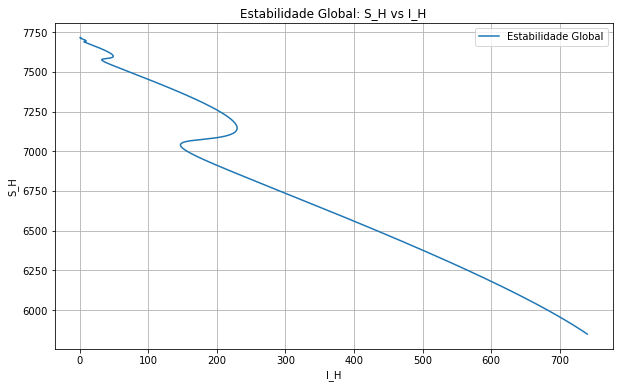

In [10]:
args = (T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0, R_H0, mu_H, k)

t_span = (0, 1825)  

initial_conditions = [S_H0, I_H0, R_H0, S_M0, E_M0, I_M0]

# Resolve o sistema de EDOs
solution = solve_ivp(model, t_span, initial_conditions,  args=args, method='RK45', dense_output=True)

# Extrai os resultados
t_values = np.linspace(t_span[0], t_span[1], 1000)
z_values = solution.sol(t_values)

# Plota S_H vs I_H
plt.figure(figsize=(10, 6))
plt.plot(z_values[1], z_values[0], label='Estabilidade Global')
plt.title('Estabilidade Global: S_H vs I_H')
plt.xlabel('I_H')
plt.ylabel('S_H')
plt.legend()
plt.grid(True)
plt.show()

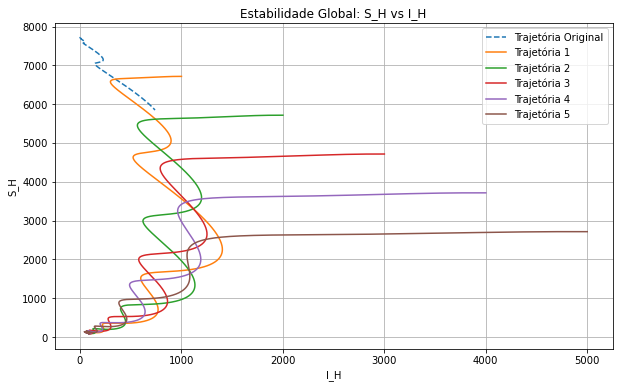

In [11]:
t_span = (0, 1825)

# Condições iniciais
initial_conditions = [S_H0, I_H0, R_H0, S_M0, E_M0, I_M0]

# Número de trajetórias a anlisar
num_trajectories = 5

# Plotagem das múltiplas trajetórias
plt.figure(figsize=(10, 6))

original_solution = solve_ivp(model, t_span, initial_conditions, args=args, method='RK45', dense_output=True)
original_z_values = original_solution.sol(t_values)
plt.plot(original_z_values[1], original_z_values[0], label='Trajetória Original', linestyle='--')    

for i in range(num_trajectories):
    
    initial_conditions[0] -= 1000  # Aumentando o número de infectados inicial em 1000
    initial_conditions[1] += 1000
    solution = solve_ivp(model, t_span, initial_conditions, args=args, method='RK45', dense_output=True)
    
    # Extrai os resultados
    t_values = np.linspace(t_span[0], t_span[1], 1000)
    z_values = solution.sol(t_values)

    # Plota S_H vs I_H para cada trajetória
    plt.plot(z_values[1], z_values[0], label=f'Trajetória {i+1}')
    
plt.title('Estabilidade Global: S_H vs I_H')
plt.xlabel('I_H')
plt.ylabel('S_H')
plt.legend()
plt.grid(True)
plt.show()

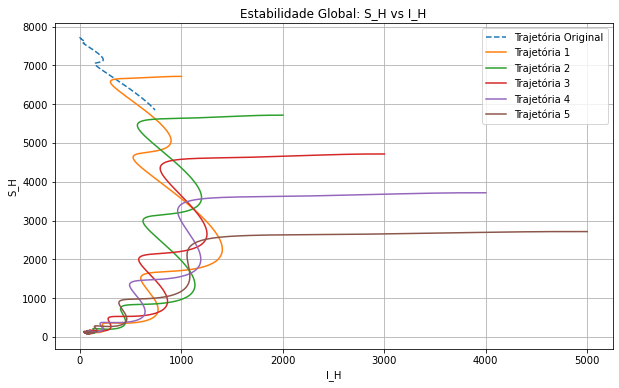

In [12]:
t_span = (0, 2825)

# Condições iniciais
initial_conditions = [S_H0, I_H0, R_H0, S_M0, E_M0, I_M0]

# Número de trajetórias a anlisar
num_trajectories = 5

# Plotagem das múltiplas trajetórias
plt.figure(figsize=(10, 6))

original_solution = solve_ivp(model, t_span, initial_conditions, args=args, method='RK45', dense_output=True)
original_z_values = original_solution.sol(t_values)
plt.plot(original_z_values[1], original_z_values[0], label='Trajetória Original', linestyle='--')    

for i in range(num_trajectories):
    
    initial_conditions[0] -= 1000  # Aumentando o número de infectados inicial em 1000
    initial_conditions[1] += 1000
    solution = solve_ivp(model, t_span, initial_conditions, args=args, method='RK45', dense_output=True)
    
    # Extrai os resultados
    t_values = np.linspace(t_span[0], t_span[1], 1000)
    z_values = solution.sol(t_values)

    # Plota S_H vs I_H para cada trajetória
    plt.plot(z_values[1], z_values[0], label=f'Trajetória {i+1}')
    
plt.title('Estabilidade Global: S_H vs I_H')
plt.xlabel('I_H')
plt.ylabel('S_H')
plt.legend()
plt.grid(True)
plt.show()

Trajetória Original termina em: S_H = 396.14267428501296, I_H = 303.7462380632941
Trajetória 5 termina em: S_H = 125.87726146031393, I_H = 62.1965929411495


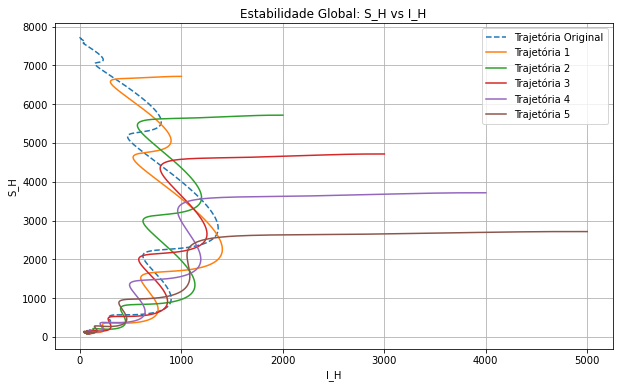

In [13]:
t_span = (0, 2825)

# Condições iniciais
initial_conditions = [S_H0, I_H0, R_H0, S_M0, E_M0, I_M0]

# Número de trajetórias a anlisar
num_trajectories = 5

# Plotagem das múltiplas trajetórias
plt.figure(figsize=(10, 6))

original_solution = solve_ivp(model, t_span, initial_conditions, args=args, method='RK45', dense_output=True)
original_z_values = original_solution.sol(t_values)
original_SH_last_value = original_z_values[0][-1]
original_IH_last_value = original_z_values[1][-1]

print(f'Trajetória Original termina em: S_H = {original_SH_last_value}, I_H = {original_IH_last_value}')

plt.plot(original_z_values[1], original_z_values[0], label='Trajetória Original', linestyle='--')    

for i in range(num_trajectories):
    
    initial_conditions[0] -= 1000  # Aumentando o número de infectados inicial em 1000
    initial_conditions[1] += 1000
    solution = solve_ivp(model, t_span, initial_conditions, args=args, method='RK45', dense_output=True)
    
    # Extrai os resultados
    t_values = np.linspace(t_span[0], t_span[1], 1000)
    z_values = solution.sol(t_values)
    
    if i == 4:  # Printa os valores da útlima trajetória
        SH_last_value = z_values[0][-1]
        IH_last_value = z_values[1][-1]
        print(f'Trajetória {i+1} termina em: S_H = {SH_last_value}, I_H = {IH_last_value}')

    # Plota S_H vs I_H para cada trajetória
    plt.plot(z_values[1], z_values[0], label=f'Trajetória {i+1}')
    
plt.title('Estabilidade Global: S_H vs I_H')
plt.xlabel('I_H')
plt.ylabel('S_H')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
k=10

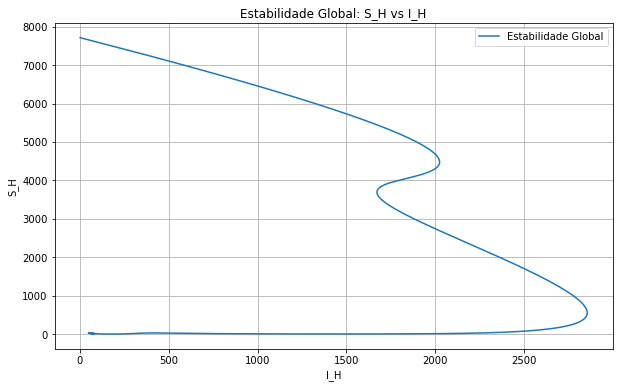

In [15]:
args = (T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0, R_H0, mu_H, k)

t_span = (0, 1825)  

initial_conditions = [S_H0, I_H0, R_H0, S_M0, E_M0, I_M0]

# Resolve o sistema de EDOs
solution = solve_ivp(model, t_span, initial_conditions,  args=args, method='RK45', dense_output=True)

# Extrai os resultados
t_values = np.linspace(t_span[0], t_span[1], 1000)
z_values = solution.sol(t_values)

# Plota S_H vs I_H
plt.figure(figsize=(10, 6))
plt.plot(z_values[1], z_values[0], label='Estabilidade Global')
plt.title('Estabilidade Global: S_H vs I_H')
plt.xlabel('I_H')
plt.ylabel('S_H')
plt.legend()
plt.grid(True)
plt.show()

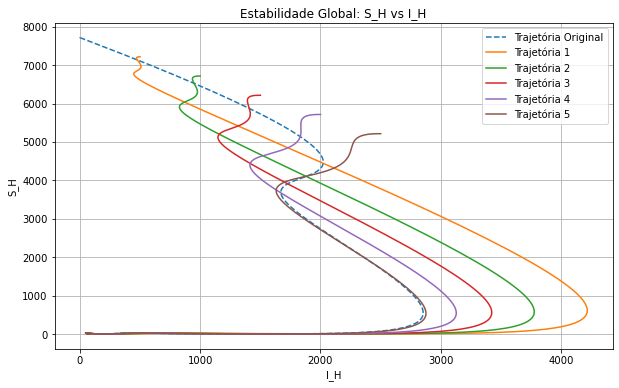

In [16]:
t_span = (0, 1825)

# Condições iniciais
initial_conditions = [S_H0, I_H0, R_H0, S_M0, E_M0, I_M0]

# Número de trajetórias a anlisar
num_trajectories = 5

# Plotagem das múltiplas trajetórias
plt.figure(figsize=(10, 6))

original_solution = solve_ivp(model, t_span, initial_conditions, args=args, method='RK45', dense_output=True)
original_z_values = original_solution.sol(t_values)
plt.plot(original_z_values[1], original_z_values[0], label='Trajetória Original', linestyle='--')    

for i in range(num_trajectories):
    
    initial_conditions[0] -= 500  # Aumentando o número de infectados inicial em 500
    initial_conditions[1] += 500
    solution = solve_ivp(model, t_span, initial_conditions, args=args, method='RK45', dense_output=True)
    
    # Extrai os resultados
    t_values = np.linspace(t_span[0], t_span[1], 1000)
    z_values = solution.sol(t_values)

    # Plota S_H vs I_H para cada trajetória
    plt.plot(z_values[1], z_values[0], label=f'Trajetória {i+1}')
    
plt.title('Estabilidade Global: S_H vs I_H')
plt.xlabel('I_H')
plt.ylabel('S_H')
plt.legend()
plt.grid(True)
plt.show()

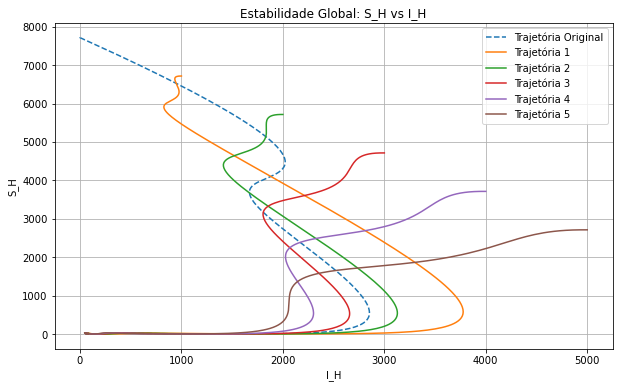

In [17]:
t_span = (0, 1825)

# Condições iniciais
initial_conditions = [S_H0, I_H0, R_H0, S_M0, E_M0, I_M0]

# Número de trajetórias a anlisar
num_trajectories = 5

# Plotagem das múltiplas trajetórias
plt.figure(figsize=(10, 6))

original_solution = solve_ivp(model, t_span, initial_conditions, args=args, method='RK45', dense_output=True)
original_z_values = original_solution.sol(t_values)
plt.plot(original_z_values[1], original_z_values[0], label='Trajetória Original', linestyle='--')    

for i in range(num_trajectories):
    
    initial_conditions[0] -= 1000  # Aumentando o número de infectados inicial em 1000
    initial_conditions[1] += 1000
    solution = solve_ivp(model, t_span, initial_conditions, args=args, method='RK45', dense_output=True)
    
    # Extrai os resultados
    t_values = np.linspace(t_span[0], t_span[1], 1000)
    z_values = solution.sol(t_values)

    # Plota S_H vs I_H para cada trajetória
    plt.plot(z_values[1], z_values[0], label=f'Trajetória {i+1}')
    
plt.title('Estabilidade Global: S_H vs I_H')
plt.xlabel('I_H')
plt.ylabel('S_H')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
k=5

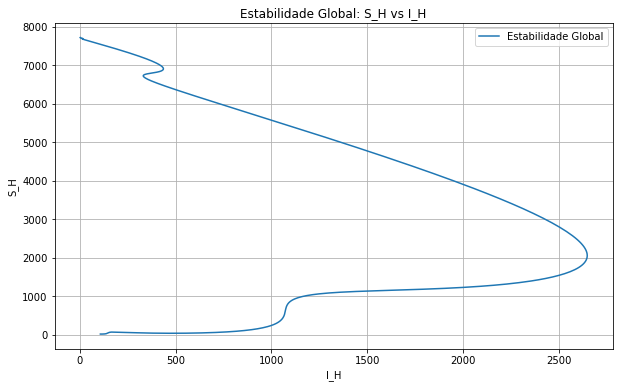

In [20]:
args = (T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0, R_H0, mu_H, k)

t_span = (0, 1825)  

initial_conditions = [S_H0, I_H0, R_H0, S_M0, E_M0, I_M0]

# Resolve o sistema de EDOs
solution = solve_ivp(model, t_span, initial_conditions,  args=args, method='RK45', dense_output=True)

# Extrai os resultados
t_values = np.linspace(t_span[0], t_span[1], 1000)
z_values = solution.sol(t_values)

# Plota S_H vs I_H
plt.figure(figsize=(10, 6))
plt.plot(z_values[1], z_values[0], label='Estabilidade Global')
plt.title('Estabilidade Global: S_H vs I_H')
plt.xlabel('I_H')
plt.ylabel('S_H')
plt.legend()
plt.grid(True)
plt.show()

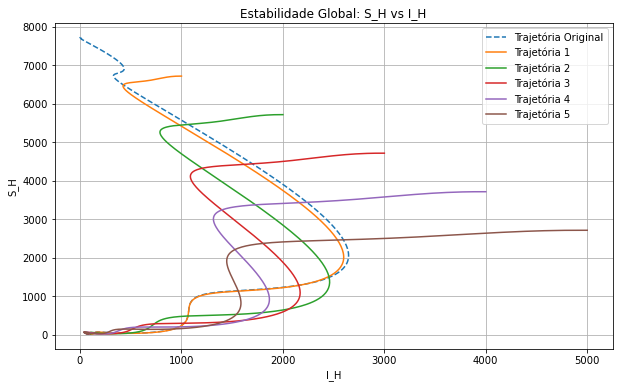

In [21]:
t_span = (0, 1825)

# Condições iniciais
initial_conditions = [S_H0, I_H0, R_H0, S_M0, E_M0, I_M0]

# Número de trajetórias a anlisar
num_trajectories = 5

# Plotagem das múltiplas trajetórias
plt.figure(figsize=(10, 6))

original_solution = solve_ivp(model, t_span, initial_conditions, args=args, method='RK45', dense_output=True)
original_z_values = original_solution.sol(t_values)
plt.plot(original_z_values[1], original_z_values[0], label='Trajetória Original', linestyle='--')    

for i in range(num_trajectories):
    
    initial_conditions[0] -= 1000  # Aumentando o número de infectados inicial em 1000
    initial_conditions[1] += 1000
    solution = solve_ivp(model, t_span, initial_conditions, args=args, method='RK45', dense_output=True)
    
    # Extrai os resultados
    t_values = np.linspace(t_span[0], t_span[1], 1000)
    z_values = solution.sol(t_values)

    # Plota S_H vs I_H para cada trajetória
    plt.plot(z_values[1], z_values[0], label=f'Trajetória {i+1}')
    
plt.title('Estabilidade Global: S_H vs I_H')
plt.xlabel('I_H')
plt.ylabel('S_H')
plt.legend()
plt.grid(True)
plt.show()

Trajetória Original termina em: S_H = 24.282026523359946, I_H = 106.88679402321985
Trajetória 5 termina em: S_H = 27.273093652343757, I_H = 78.2792157970932


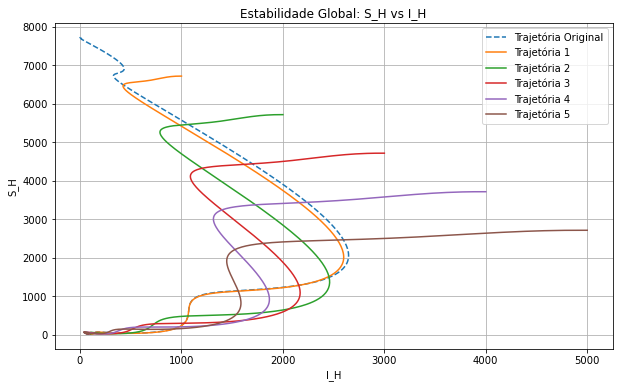

In [22]:
t_span = (0, 1825)

# Condições iniciais
initial_conditions = [S_H0, I_H0, R_H0, S_M0, E_M0, I_M0]

# Número de trajetórias a anlisar
num_trajectories = 5

# Plotagem das múltiplas trajetórias
plt.figure(figsize=(10, 6))

original_solution = solve_ivp(model, t_span, initial_conditions, args=args, method='RK45', dense_output=True)
original_z_values = original_solution.sol(t_values)
original_SH_last_value = original_z_values[0][-1]
original_IH_last_value = original_z_values[1][-1]

print(f'Trajetória Original termina em: S_H = {original_SH_last_value}, I_H = {original_IH_last_value}')

plt.plot(original_z_values[1], original_z_values[0], label='Trajetória Original', linestyle='--')    

for i in range(num_trajectories):
    
    initial_conditions[0] -= 1000  # Aumentando o número de infectados inicial em 1000
    initial_conditions[1] += 1000
    solution = solve_ivp(model, t_span, initial_conditions, args=args, method='RK45', dense_output=True)
    
    # Extrai os resultados
    t_values = np.linspace(t_span[0], t_span[1], 1000)
    z_values = solution.sol(t_values)
    
    if i == 4:  # Printa os valores da útlima trajetória
        SH_last_value = z_values[0][-1]
        IH_last_value = z_values[1][-1]
        print(f'Trajetória {i+1} termina em: S_H = {SH_last_value}, I_H = {IH_last_value}')

    # Plota S_H vs I_H para cada trajetória
    plt.plot(z_values[1], z_values[0], label=f'Trajetória {i+1}')
    
plt.title('Estabilidade Global: S_H vs I_H')
plt.xlabel('I_H')
plt.ylabel('S_H')
plt.legend()
plt.grid(True)
plt.show()